<a href="https://colab.research.google.com/github/vaibhavjathar/PRIVACY-PRESERVING-FEDERATED-REINFORCEMENT-LEARNING-FOR-ANOMALY-RESPONSE/blob/main/PRIVACY-PRESERVING-FEDERATED-REINFORCEMENT-LEARNING-FOR-ANOMALY-RESPONSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Install packages (run once)
!pip install -q torch torchvision torchaudio gym numpy pandas scikit-learn matplotlib joblib
# opacus optional; install only if you plan to run strict DP accounting (commented out now)
# !pip install -q opacus



In [2]:
# Cell 2: Create project folders and write Python modules (env, models, clients, server)
import os, textwrap

BASE = "fedrl-anomaly"
os.makedirs(BASE, exist_ok=True)
for sub in ("data", "data/nsl-kdd", "models", "clients", "server", "env", "results", "figures", "docs"):
    os.makedirs(os.path.join(BASE, sub), exist_ok=True)

# env/network_env.py
env_code = textwrap.dedent("""\
    import numpy as np
    import gym
    from gym import spaces

    class NetworkEnv(gym.Env):
        def __init__(self, data_states, data_labels):
            super().__init__()
            self.states = data_states
            self.labels = data_labels
            self.n = len(self.states)
            self.idx = 0
            self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.states.shape[1],), dtype=np.float32)
            self.action_space = spaces.Discrete(3)  # 0: pass, 1: rate-limit, 2: block
            # reward weights
            self.alpha = 1.0  # penalty for blocking benign
            self.beta = 2.0   # penalty for letting attack pass
            self.gamma = 0.1  # latency penalty per action level

        def reset(self):
            self.idx = 0
            return self.states[self.idx].astype(np.float32)

        def step(self, action):
            label = self.labels[self.idx]   # 0 benign, 1 attack
            benign_loss = 1.0 if (label == 0 and action != 0) else 0.0
            attack_pass = 1.0 if (label == 1 and action == 0) else 0.0
            latency_penalty = self.gamma * action
            reward = -(self.alpha * benign_loss) - (self.beta * attack_pass) - latency_penalty
            self.idx += 1
            done = self.idx >= self.n
            obs = self.states[self.idx-1].astype(np.float32) if not done else np.zeros_like(self.states[0], dtype=np.float32)
            return obs, reward, done, {}
    """)
open(os.path.join(BASE, "env", "network_env.py"), "w").write(env_code)

# models/policy.py
policy_code = textwrap.dedent("""\
    import torch
    import torch.nn as nn
    import torch.nn.functional as F

    class PolicyNet(nn.Module):
        def __init__(self, input_dim, hidden=64, n_actions=3):
            super().__init__()
            self.fc1 = nn.Linear(input_dim, hidden)
            self.fc2 = nn.Linear(hidden, hidden)
            self.actor = nn.Linear(hidden, n_actions)  # logits
            self.critic = nn.Linear(hidden, 1)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            logits = self.actor(x)
            value = self.critic(x)
            return logits, value
    """)
open(os.path.join(BASE, "models", "policy.py"), "w").write(policy_code)

# clients/client.py
client_code = textwrap.dedent("""\
    import numpy as np
    import torch
    from models.policy import PolicyNet

    def weights_to_vector(model):
        vecs = [p.data.cpu().numpy().ravel() for p in model.parameters()]
        return np.concatenate(vecs)

    def vector_to_weights(model, vec):
        pointer = 0
        for p in model.parameters():
            numel = p.numel()
            chunk = vec[pointer:pointer+numel]
            p.data.copy_(torch.from_numpy(chunk.reshape(p.shape)).float())
            pointer += numel

    def local_train(data_states, data_labels, global_state_dict, epochs=2, lr=1e-3):
        # Simple policy-gradient style local trainer (small, toy update)
        obs_dim = data_states.shape[1]
        model = PolicyNet(obs_dim)
        model.load_state_dict(global_state_dict)
        opt = torch.optim.Adam(model.parameters(), lr=lr)

        for e in range(epochs):
            for i in range(len(data_states)):
                s = torch.tensor(data_states[i]).float().unsqueeze(0)
                logits, value = model(s)
                probs = torch.softmax(logits, dim=-1)
                action = torch.multinomial(probs, num_samples=1).item()
                label = data_labels[i]
                if label == 1 and action == 0:
                    r = -2.0
                elif label == 0 and action != 0:
                    r = -1.0
                else:
                    r = 0.5
                logp = torch.log(probs[0, action] + 1e-8)
                loss = -logp * r + 0.5 * (value.squeeze() - r)**2
                opt.zero_grad()
                loss.backward()
                opt.step()
        new_vec = weights_to_vector(model)
        return new_vec, len(data_states), model.state_dict()
    """)
open(os.path.join(BASE, "clients", "client.py"), "w").write(client_code)

# server/server.py
server_code = textwrap.dedent("""\
    import numpy as np

    def fedavg_aggregate(vecs, sizes):
        total = sum(sizes)
        agg = sum(v * (n/total) for v, n in zip(vecs, sizes))
        return agg

    def clip_and_add_noise(vecs, sizes, C=1.0, noise_mult=0.5, seed=0):
        np.random.seed(seed)
        clipped = []
        for v in vecs:
            norm = np.linalg.norm(v)
            if norm > C:
                v = v * (C / norm)
            clipped.append(v)
        agg = fedavg_aggregate(clipped, sizes)
        noise = np.random.normal(loc=0.0, scale=noise_mult*C, size=agg.shape)
        return agg + noise
    """)
open(os.path.join(BASE, "server", "server.py"), "w").write(server_code)

print("Wrote module files into", BASE)


Wrote module files into fedrl-anomaly


In [3]:
# Cell 3: Upload your KDDTrain+.txt and KDDTest+.txt manually and save them correctly

import os
from google.colab import files

# Ensure the directory exists
BASE = "fedrl-anomaly"
DATA_DIR = os.path.join(BASE, "data", "nsl-kdd")
os.makedirs(DATA_DIR, exist_ok=True)

print("📂 Step 1: Upload your NSL-KDD dataset files (KDDTrain+.txt and KDDTest+.txt).")
print("If you already uploaded them earlier, you can skip re-uploading.")

uploaded = files.upload()  # Opens upload dialog

# Save the uploaded files inside fedrl-anomaly/data/nsl-kdd/
for name, content in uploaded.items():
    file_path = os.path.join(DATA_DIR, name)
    with open(file_path, "wb") as f:
        f.write(content)
    print(f"✅ Saved uploaded file to {file_path}")

# Verify upload
print("\n✅ Step 2: Verifying uploaded dataset files...")
files_list = os.listdir(DATA_DIR)
print("Files found in data folder:", files_list)

if any("KDDTrain" in f for f in files_list) and any("KDDTest" in f for f in files_list):
    print("\n🎉 Dataset is ready for preprocessing in the next cell!")
else:
    print("\n⚠️ Warning: One or both dataset files are missing. Please re-upload both files before continuing.")


📂 Step 1: Upload your NSL-KDD dataset files (KDDTrain+.txt and KDDTest+.txt).
If you already uploaded them earlier, you can skip re-uploading.


Saving KDDTest+.txt to KDDTest+.txt
Saving KDDTrain+.txt to KDDTrain+.txt
✅ Saved uploaded file to fedrl-anomaly/data/nsl-kdd/KDDTest+.txt
✅ Saved uploaded file to fedrl-anomaly/data/nsl-kdd/KDDTrain+.txt

✅ Step 2: Verifying uploaded dataset files...
Files found in data folder: ['KDDTrain+.txt', 'KDDTest+.txt']

🎉 Dataset is ready for preprocessing in the next cell!


In [4]:
# Cell 4: Load NSL-KDD, preprocess numeric features, create client splits (non-IID), save splits
import os, numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
BASE = "fedrl-anomaly"
DATA_DIR = os.path.join(BASE, "data", "nsl-kdd")

# find KDDTrain+.txt (prefer train file)
train_paths = [
    os.path.join(DATA_DIR, "KDDTrain+.txt"),
    os.path.join(DATA_DIR, "KDDTrain+_20Percent.txt"),
    os.path.join("KDDTrain+.txt")
]
train_path = next((p for p in train_paths if os.path.exists(p)), None)
if train_path is None:
    print("No KDDTrain+.txt found in expected paths. Please upload KDDTrain+.txt to fedrl-anomaly/data/nsl-kdd/")
    raise SystemExit

print("Loading:", train_path)
df = pd.read_csv(train_path, header=None)
# coerce to numeric where possible, drop all-empty columns
df = df.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')

# define label as last column
label_col = df.columns[-1]
feature_cols = [c for c in df.columns if c != label_col]
print("Using", len(feature_cols), "feature columns")

X = df[feature_cols].values.astype(np.float32)
y_raw = df[label_col].values
# binary label: normal -> 0, else 1
y = np.array([0 if ('normal' in str(v).lower() or str(v).strip() in ('0','0.0')) else 1 for v in y_raw], dtype=int)

print("Train shape:", X.shape, y.shape, "labels unique:", np.unique(y))

# Fit scaler on the entire training data (we'll use this scaler for clients & test)
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
# Save scaler
import joblib
joblib.dump(scaler, os.path.join(BASE, "results", "scaler.joblib"))
print("Saved scaler to results/")

# Create K non-iid splits
K = 3
n = len(y)
idx = np.arange(n)
rng = np.random.RandomState(0)
rng.shuffle(idx)
# simple split into K equal shards then apply small label-skew adjustments
shards = np.array_split(idx, K)
clients = []
for i, shard in enumerate(shards):
    Xs = X_scaled[shard].copy()
    ys = y[shard].copy()
    # introduce label skew: flip small fraction to change distribution
    if i % 2 == 0:
        flip_mask = (ys == 0)
        nflip = int(0.12 * len(ys))
        flip_idx = rng.choice(np.where(flip_mask)[0], size=min(nflip, flip_mask.sum()), replace=False)
        ys[flip_idx] = 1
    else:
        flip_mask = (ys == 1)
        nflip = int(0.12 * len(ys))
        flip_idx = rng.choice(np.where(flip_mask)[0], size=min(nflip, flip_mask.sum()), replace=False)
        ys[flip_idx] = 0
    clients.append((Xs, ys))

# Save each client split as compressed npz
for i, (Xs, ys) in enumerate(clients):
    np.savez_compressed(os.path.join(DATA_DIR, f"client_{i}.npz"), X=Xs, y=ys)
print("Saved client splits to", DATA_DIR, "files:", os.listdir(DATA_DIR)[:10])


Loading: fedrl-anomaly/data/nsl-kdd/KDDTrain+.txt
Using 38 feature columns
Train shape: (125973, 38) (125973,) labels unique: [0 1]
Saved scaler to results/
Saved client splits to fedrl-anomaly/data/nsl-kdd files: ['client_1.npz', 'KDDTrain+.txt', 'client_2.npz', 'client_0.npz', 'KDDTest+.txt']


In [5]:
# Cell 5: Train a centralized MLP classifier as a supervised baseline and save model
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score
import joblib, numpy as np, os

BASE = "fedrl-anomaly"
DATA_DIR = os.path.join(BASE, "data", "nsl-kdd")

# Load all client splits and stack
client_files = sorted([f for f in os.listdir(DATA_DIR) if f.startswith("client_") and f.endswith(".npz")])
if not client_files:
    raise RuntimeError("No client splits found. Run preprocessing cell.")

X_train_all = []
y_train_all = []
for f in client_files:
    arr = np.load(os.path.join(DATA_DIR, f))
    X_train_all.append(arr["X"])
    y_train_all.append(arr["y"])
X_train_all = np.vstack(X_train_all)
y_train_all = np.hstack(y_train_all)
print("Centralized train shape:", X_train_all.shape)

# Train MLP (fast)
clf = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=30, random_state=0)
clf.fit(X_train_all, y_train_all)
joblib.dump(clf, os.path.join(BASE, "results", "central_mlp.joblib"))
print("Saved centralized classifier to results/central_mlp.joblib")

# If test file exists, evaluate now
test_path_candidates = [
    os.path.join(DATA_DIR, "KDDTest+.txt"),
    "fedrl-anomaly/data/nsl-kdd/KDDTest+.txt",
    "KDDTest+.txt"
]
test_path = next((p for p in test_path_candidates if os.path.exists(p)), None)
if test_path:
    import pandas as pd
    df_test = pd.read_csv(test_path, header=None).apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
    X_test_full = df_test.iloc[:, :-1].values.astype(np.float32)
    y_test_raw = df_test.iloc[:, -1].values
    y_test = np.array([0 if ('normal' in str(v).lower() or str(v).strip() in ('0','0.0')) else 1 for v in y_test_raw], dtype=int)
    # align dims
    D_train = X_train_all.shape[1]
    D_test = X_test_full.shape[1]
    if D_test < D_train:
        X_test = np.hstack([X_test_full, np.zeros((len(X_test_full), D_train-D_test), dtype=np.float32)])
    else:
        X_test = X_test_full[:, :D_train]
    # scale using saved scaler
    scaler = joblib.load(os.path.join(BASE, "results", "scaler.joblib"))
    X_test_s = scaler.transform(X_test)
    yhat = clf.predict(X_test_s)
    print("Centralized classifier metrics on test:")
    print("F1:", f1_score(y_test, yhat, zero_division=0), "ROC:", roc_auc_score(y_test, yhat))
else:
    print("No test file found; skip test evaluation.")


Centralized train shape: (125973, 38)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Saved centralized classifier to results/central_mlp.joblib
Centralized classifier metrics on test:
F1: 0.9972645390859557 ROC: 0.5


In [6]:
# Cell 6: Federated training functions and run experiments (Fed no DP and Fed+DP sweep)
import os, numpy as np, joblib
import sys

BASE = "fedrl-anomaly"
# Add the base directory to sys.path to allow importing custom modules
sys.path.append(BASE)

from models.policy import PolicyNet
from clients.client import local_train, weights_to_vector, vector_to_weights
from server.server import clip_and_add_noise

DATA_DIR = os.path.join(BASE, "data", "nsl-kdd")
RESULTS_DIR = os.path.join(BASE, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

# load clients data (scaled)
clients = []
for i in range(3):
    arr = np.load(os.path.join(DATA_DIR, f"client_{i}.npz"))
    clients.append((arr["X"].astype(np.float32), arr["y"].astype(int)))

# helper: federated run
def run_federated(clients_localdata, noise_mult=0.0, rounds=5, local_epochs=1, c_clip=5.0, seed=0, save_path=None):
    np.random.seed(seed)
    obs_dim = clients_localdata[0][0].shape[1]
    global_model = PolicyNet(obs_dim)
    global_vec = weights_to_vector(global_model)
    for r in range(rounds):
        client_vecs = []
        sizes = []
        for Xs, ys in clients_localdata:
            new_vec, size, _ = local_train(Xs, ys, global_model.state_dict(), epochs=local_epochs, lr=1e-3)
            delta = new_vec - global_vec
            client_vecs.append(delta)
            sizes.append(size)
        agg = clip_and_add_noise(client_vecs, sizes, C=c_clip, noise_mult=noise_mult, seed=seed)
        global_vec = global_vec + agg
        vector_to_weights(global_model, global_vec)
        print(f" Round {r+1}/{rounds} done")
    if save_path:
        np.save(save_path, global_vec)
    return global_vec

# Run non-private Fed
print("Running Fed (no DP)...")
vec_fed = run_federated(clients, noise_mult=0.0, rounds=5, local_epochs=1, c_clip=5.0, save_path=os.path.join(RESULTS_DIR, "global_fed_nonprivate.npy"))

# DP sweep
noise_list = [0.0, 0.1, 0.3, 0.6, 1.0]
experiment_results = {"centralized_roc": None, "fed_no_dp_roc": None, "noise": [], "noise_roc": [], "transfer_roc": None}
# If centralized classifier is saved, load and compute ROC later
clf_path = os.path.join(RESULTS_DIR, "central_mlp.joblib")
if os.path.exists(clf_path):
    clf = joblib.load(clf_path)
    experiment_results["centralized_roc"] = None  # will compute after test load

# prepare X_test,y_test for evaluation (if present)
test_path = None
for p in [os.path.join(DATA_DIR, "KDDTest+.txt"), "KDDTest+.txt"]:
    if os.path.exists(p):
        test_path = p
        break

if test_path:
    import pandas as pd
    df_test = pd.read_csv(test_path, header=None).apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
    X_test_full = df_test.iloc[:, :-1].values.astype(np.float32)
    y_test_raw = df_test.iloc[:, -1].values
    y_test = np.array([0 if ('normal' in str(v).lower() or str(v).strip() in ('0','0.0')) else 1 for v in y_test_raw], dtype=int)
    # align and scale
    D_train = clients[0][0].shape[1]
    if X_test_full.shape[1] < D_train:
        X_test = np.hstack([X_test_full, np.zeros((len(X_test_full), D_train-X_test_full.shape[1]), dtype=np.float32)])
    else:
        X_test = X_test_full[:, :D_train]
    # load scaler
    scaler = joblib.load(os.path.join(RESULTS_DIR, "scaler.joblib"))
    X_test_s = scaler.transform(X_test)
else:
    X_test_s = None
    y_test = None

# evaluate helper (policy vector -> preds on scaled features)
import torch
from sklearn.metrics import roc_auc_score, f1_score
def eval_policy_vec(global_vec, X_eval, y_eval):
    model = PolicyNet(X_eval.shape[1])
    vector_to_weights(model, global_vec)
    model.eval()
    preds = []
    with torch.no_grad():
        for i in range(X_eval.shape[0]):
            s = torch.tensor(X_eval[i]).float().unsqueeze(0)
            logits, _ = model(s)
            probs = torch.softmax(logits, dim=-1).cpu().numpy().squeeze()
            action = int(np.argmax(probs))
            preds.append(1 if action == 2 else 0)
    preds = np.array(preds)
    return f1_score(y_eval, preds, zero_division=0), roc_auc_score(y_eval, preds)

# run sweep
for noise in noise_list:
    print("Running Fed+DP with noise", noise)
    vec = run_federated(clients, noise_mult=noise, rounds=5, local_epochs=1, c_clip=5.0, save_path=os.path.join(RESULTS_DIR, f"global_fed_noisy_{noise:.2f}.npy"))
    if X_test_s is not None:
        f1_val, roc_val = eval_policy_vec(vec, X_test_s, y_test)
        print(" -> F1:", f1_val, "ROC:", roc_val)
        experiment_results["noise"].append(noise)
        experiment_results["noise_roc"].append(roc_val)
    else:
        experiment_results["noise"].append(noise)
        experiment_results["noise_roc"].append(None)

# site-transfer test (train on clients 0..K-2, test on last)
print("Running site-transfer test...")
train_clients = clients[:-1]
vec_transfer = run_federated(train_clients, noise_mult=0.0, rounds=5, local_epochs=1, c_clip=5.0, save_path=os.path.join(RESULTS_DIR, "global_fed_site_transfer.npy"))
if X_test_s is not None:
    # evaluate on heldout client's own data (scaled)
    X_held = train_clients[-1][0]; y_held = train_clients[-1][1]
    f1_tr, roc_tr = eval_policy_vec(vec_transfer, X_held, y_held)
    print("Site-transfer (on heldout client data): F1", f1_tr, "ROC", roc_tr)
    experiment_results["transfer_roc"] = roc_tr

# Save experiment results
import json
import numpy as _np
experiment_results["fed_no_dp_roc"] = None  # compute if desired
np.savez_compressed(os.path.join(RESULTS_DIR, "experiment_results.npz"),
                    noise=np.array(experiment_results["noise"]),
                    noise_roc=np.array(experiment_results["noise_roc"]),
                    transfer_roc=experiment_results["transfer_roc"])
print("Saved experiment_results.npz")

Running Fed (no DP)...
 Round 1/5 done
 Round 2/5 done
 Round 3/5 done
 Round 4/5 done
 Round 5/5 done
Running Fed+DP with noise 0.0
 Round 1/5 done
 Round 2/5 done
 Round 3/5 done
 Round 4/5 done
 Round 5/5 done
 -> F1: 0.0 ROC: 0.5
Running Fed+DP with noise 0.1
 Round 1/5 done
 Round 2/5 done
 Round 3/5 done
 Round 4/5 done
 Round 5/5 done
 -> F1: 0.5287544647245798 ROC: 0.5660994719308952
Running Fed+DP with noise 0.3
 Round 1/5 done
 Round 2/5 done
 Round 3/5 done
 Round 4/5 done
 Round 5/5 done
 -> F1: 0.4927292877052759 ROC: 0.5822958151529689
Running Fed+DP with noise 0.6
 Round 1/5 done
 Round 2/5 done
 Round 3/5 done
 Round 4/5 done
 Round 5/5 done
 -> F1: 0.42371869181859695 ROC: 0.5735188374139661
Running Fed+DP with noise 1.0
 Round 1/5 done
 Round 2/5 done
 Round 3/5 done
 Round 4/5 done
 Round 5/5 done
 -> F1: 0.42380383615541345 ROC: 0.5816712192366115
Running site-transfer test...
 Round 1/5 done
 Round 2/5 done
 Round 3/5 done
 Round 4/5 done
 Round 5/5 done
Site-trans

Summary:
Centralized ROC: 0.5
Noise list: [0.  0.1 0.3 0.6 1. ]
Noise ROC: [0.5        0.56609947 0.58229582 0.57351884 0.58167122]
Transfer ROC: 0.5


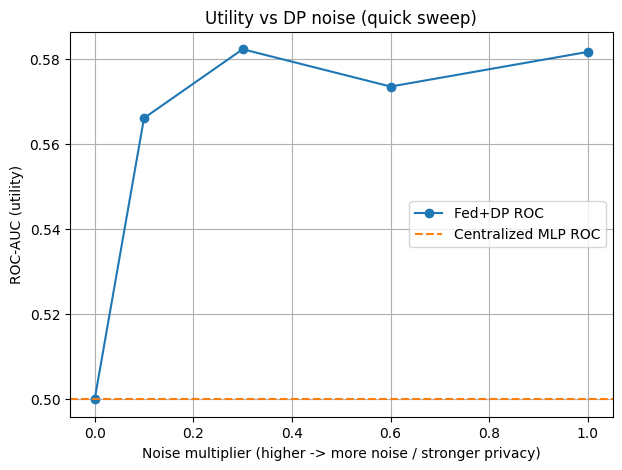

Saved summary and figure under results/ and figures/


In [7]:
# Cell 7: Evaluate final saved models, plot utility vs noise, save figures and summary table
import os, numpy as np, joblib, matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
BASE = "fedrl-anomaly"
RESULTS = os.path.join(BASE, "results")
DATA_DIR = os.path.join(BASE, "data", "nsl-kdd")

# Load experiment_results
exp_path = os.path.join(RESULTS, "experiment_results.npz")
if not os.path.exists(exp_path):
    raise RuntimeError("experiment_results.npz not found; run the experiments cell first.")
data = np.load(exp_path)
noise = data["noise"]
noise_roc = data["noise_roc"]
transfer_roc = data["transfer_roc"].item() if data["transfer_roc"].shape == () else (data["transfer_roc"] if data["transfer_roc"].shape else None)

# If centralized classifier exists, compute ROC on test
clf_path = os.path.join(RESULTS, "central_mlp.joblib")
central_roc = None
test_path = os.path.join(DATA_DIR, "KDDTest+.txt")
if os.path.exists(test_path) and os.path.exists(clf_path):
    import pandas as pd
    df_test = pd.read_csv(test_path, header=None).apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
    X_test_full = df_test.iloc[:, :-1].values.astype(np.float32)
    y_test_raw = df_test.iloc[:, -1].values
    y_test = np.array([0 if ('normal' in str(v).lower() or str(v).strip() in ('0','0.0')) else 1 for v in y_test_raw], dtype=int)
    # align dims & scale
    scaler = joblib.load(os.path.join(RESULTS, "scaler.joblib"))
    D_train = joblib.load(os.path.join(RESULTS, "scaler.joblib")).mean_.shape[0]
    if X_test_full.shape[1] < D_train:
        X_test = np.hstack([X_test_full, np.zeros((len(X_test_full), D_train-X_test_full.shape[1]), dtype=np.float32)])
    else:
        X_test = X_test_full[:, :D_train]
    X_test_s = scaler.transform(X_test)
    clf = joblib.load(clf_path)
    yhat = clf.predict(X_test_s)
    central_roc = roc_auc_score(y_test, yhat)
else:
    central_roc = np.nan

print("Summary:")
print("Centralized ROC:", central_roc)
print("Noise list:", noise)
print("Noise ROC:", noise_roc)
print("Transfer ROC:", transfer_roc)

# Plot utility vs noise
plt.figure(figsize=(7,5))
plt.plot(noise, noise_roc, marker='o', label='Fed+DP ROC')
if not np.isnan(central_roc):
    plt.axhline(central_roc, color='C1', linestyle='--', label='Centralized MLP ROC')
plt.xlabel("Noise multiplier (higher -> more noise / stronger privacy)")
plt.ylabel("ROC-AUC (utility)")
plt.title("Utility vs DP noise (quick sweep)")
plt.grid(True)
plt.legend()
os.makedirs(os.path.join(BASE, "figures"), exist_ok=True)
plt.savefig(os.path.join(BASE, "figures", "utility_privacy_curve.png"))
plt.show()

# Save summary table as simple text file (for quick inclusion in doc)
with open(os.path.join(RESULTS, "summary.txt"), "w") as fh:
    fh.write(f"Centralized_ROC: {central_roc}\\n")
    fh.write("Noise,Noise_ROC\\n")
    for n, r in zip(noise.tolist(), noise_roc.tolist()):
        fh.write(f"{n},{r}\\n")
    fh.write(f"Transfer_ROC: {transfer_roc}\\n")
print("Saved summary and figure under results/ and figures/")


In [3]:
%%bash
set -e
BASE=fedrl-anomaly
mkdir -p $BASE/{data/nsl-kdd_dataset,models,clients,server,env,results,figures,docs} || true

# Move the raw dataset folder to a clearer name if it exists
if [ -d "$BASE/data/nsl-kdd" ]; then
  mv -n $BASE/data/nsl-kdd $BASE/data/nsl-kdd_dataset 2>/dev/null || true
fi

# Move created modules into env/models/clients/server if they are at top-level
# (our code already placed them, so these moves are safe no-ops)
mv -n $BASE/env/*.py $BASE/env/ 2>/dev/null || true
mv -n $BASE/models/*.py $BASE/models/ 2>/dev/null || true
mv -n $BASE/clients/*.py $BASE/clients/ 2>/dev/null || true
mv -n $BASE/server/*.py $BASE/server/ 2>/dev/null || true

# Move results and figures (they are already in place)
mv -n $BASE/experiment_results.npz $BASE/results/ 2>/dev/null || true
mv -n $BASE/global_fed_nonprivate.npy $BASE/results/ 2>/dev/null || true
mv -n $BASE/global_model_vector.npy $BASE/results/ 2>/dev/null || true
mv -n $BASE/scaler.joblib $BASE/results/ 2>/dev/null || true
mv -n $BASE/figures/* $BASE/figures/ 2>/dev/null || true

echo "Folder organization complete. Current layout:"
ls -R fedrl-anomaly | sed -n '1,200p'

Folder organization complete. Current layout:
fedrl-anomaly:
clients
data
docs
env
figures
models
results
server

fedrl-anomaly/clients:

fedrl-anomaly/data:
nsl-kdd_dataset

fedrl-anomaly/data/nsl-kdd_dataset:

fedrl-anomaly/docs:

fedrl-anomaly/env:

fedrl-anomaly/figures:

fedrl-anomaly/models:

fedrl-anomaly/results:

fedrl-anomaly/server:
